In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from selective_gp.utils import (
    load_data, get_model, remove_points, fit_layerwise)
from selective_gp.utils.visualization import (
    plot_density, plot_samples, plot_latent)

sns.set(
    font_scale=1.5,
    style="whitegrid",
)
fig_width = 16

$
\newcommand{\f}{\mathbf{f}}
\newcommand{\u}{\mathbf{u}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\Z}{\mathbf{Z}}
\renewcommand{\d}{\;\mathrm{d}}
$

# Introduction

In this notebook we illustrate the concepts laid out in the paper "Probabilistic selection of inducing points in sparse Gaussian processes".

Given a sparse Gausian process (GP) model we consider the problem of identifying a set of inducing points that balances the model complexity (i.e. number of inducing points) against explaining the data. The basic idea is to place a prior on the *selection* of inducing points such that it can be included directly in the Bayesian inference:

$$
p(\y \mid \X) = \sum_{\Z \in \mathcal{Z}}\left[\int\int p(\y \mid \f)p(\f \mid \u, \X, \Z)p(\u \mid \Z) \d\f\d\u\right]p(\Z) 
$$

Here, $p(\Z)$ is a point process that assigns probability to any given set of inducing points from a given domain, $\mathcal{Z}$. We consider a simple form, that encourages smaller sets of inducing points:
$$
p_\alpha(\Z) = -C\exp(-\alpha\lvert \Z \rvert^2).
$$
The true posterior over $Z$ is approximated through variational inference. We use as variational distribution a discrete Poisson Point Process (PPP) that assigns independent probability to elements from a pre-defined *candidate* set of points:
$$
q_\lambda(\Z) = \prod_{\z_k \in \Z} \lambda_k \prod_{\z_k \notin \Z} (1 - \lambda_k).
$$

# SVGP 1D regression

We consider fitting a sparse variational GP (SVGP) to noisy samples drawn from a GP in the range $(0, 50)$. To ensure a setting where some of the initial inducing points do not contribute much and therefore ought to be removed, we make a gap in the data between $x = (15, 35)$ and initialise the inducing inputs over the range $(-10, 60)$.

In [2]:
dataset = load_data("synthetic_regression", input_dims=1, seed=5,
                    n_observations=200, x_min=0, x_max=50, obs_noise=0.1)
X, Y = dataset.X_train, dataset.Y_train
M = 50
mask = ((X < 15) | (35 < X)).flatten()
X = X[mask]
Y = Y[mask]
model = get_model(dataset, n_inducing=M, scale_X=False, scale_Y=False)
gp, = model.gps
gp.inducing_inputs = torch.linspace(-10, 60, M)

In [3]:
def plot_svgp(ax=None):
    if ax is None:
        ax = plt.subplots(figsize=(fig_width, 5))[1]
    ax.set_xlim(-10, 60)
    ax.margins(x=0)
    
    x_in = torch.linspace(-10, 60, 500)
    plot_latent(gp, ax)
    ax.plot(X.flatten(), Y.flatten(), "x", color=plt.cm.Greys(0.9, 0.5))

def plot_probabilities(ax=None):
    if ax is None:
        ax = plt.subplots(figsize=(fig_width, 5))[1]

    with torch.no_grad():
        x_u = gp.inducing_inputs.clone().flatten()
        p = gp.variational_point_process.probabilities

    cm = plt.cm.Set1
    ax.bar(x_u, p, color=cm(0, 0.5), width=2, edgecolor=cm(0))
    ax.set_ylim(0, 1)

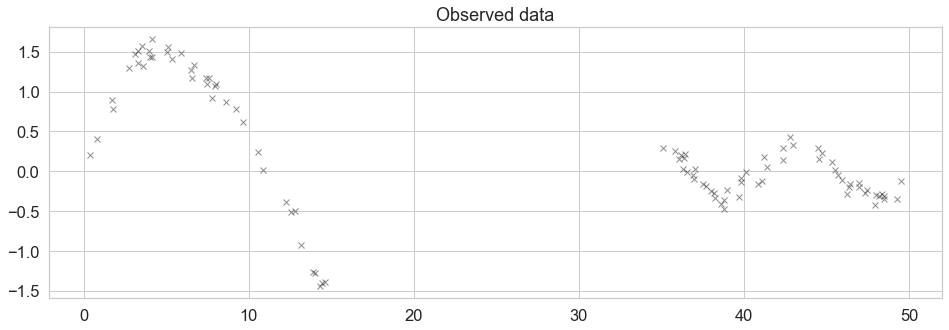

In [4]:
fig, ax = plt.subplots(figsize=(fig_width, 5))
ax.set_title("Observed data")
ax.plot(X.flatten(), Y.flatten(), "x", color=plt.cm.Greys(0.9, 0.5));

We first fit for 500 epochs to get an approximation of inducing points and hyper-parameters.

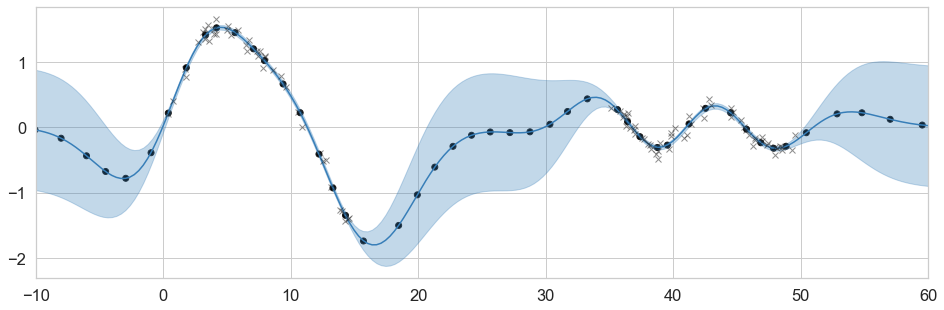

In [5]:
model.fit(X=X, Y=Y, max_epochs=500)
plot_svgp()

The black dots are inducing points and the blue line and shading are resp. mean and standard deviation of the SVGP. Note that there are plenty of inducing points that could be removed without much detriment to the predictive posterior, thus decreasing space and time complexity of the model.

To identify these "superfluous" points in a data-driven manner, we estimate the posterior probability of inclusion through score function estimation. While doing so, all other parameters of the model are locked (this restriction could be lifted, but we have opted for a simple implementation that still yields robust results).

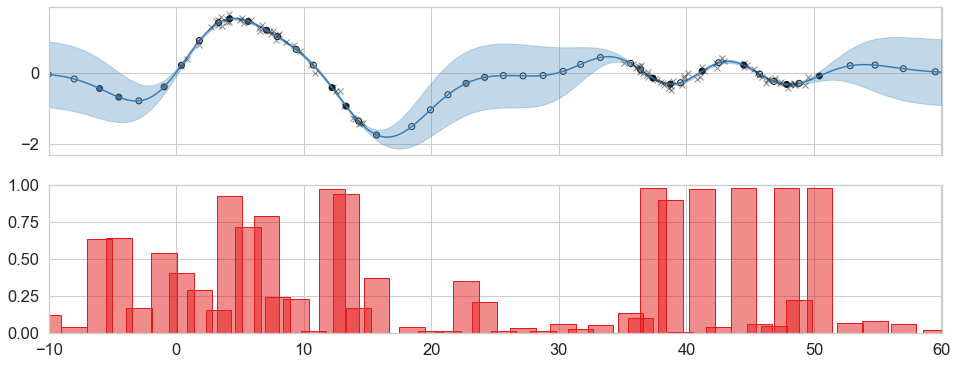

In [7]:
gp.prior_point_process.rate.fill_(1)
gp.variational_point_process.probabilities = 0.3
model.fit_score_function_estimator(
    X=X, Y=Y, learning_rate=0.3, max_epochs=100,
    n_mcmc_samples=8)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, 6), sharex=True)
plot_svgp(ax1)
plot_probabilities(ax2)

The lower panel show the probability of inclusion. Although we have only trained for 100 epochs, we already see a tendency to favour inducing points which are located next to the two clusters of data.

We proceed with another 500 epochs to get a more stable estimate.

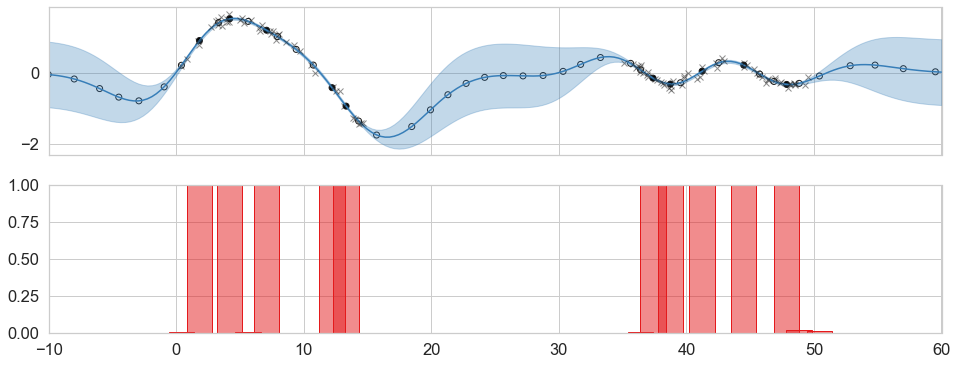

In [8]:
model.fit_score_function_estimator(
        X=X, Y=Y, learning_rate=0.3, max_epochs=500,
    n_mcmc_samples=8)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, 6), sharex=True)
plot_svgp(ax1)
plot_probabilities(ax2)

At this point, the PPP has locked in on a small subset of points to represent the function. Sampling from the resulting distribution over inducing points and refitting, we arrive at a heavily pruned model.

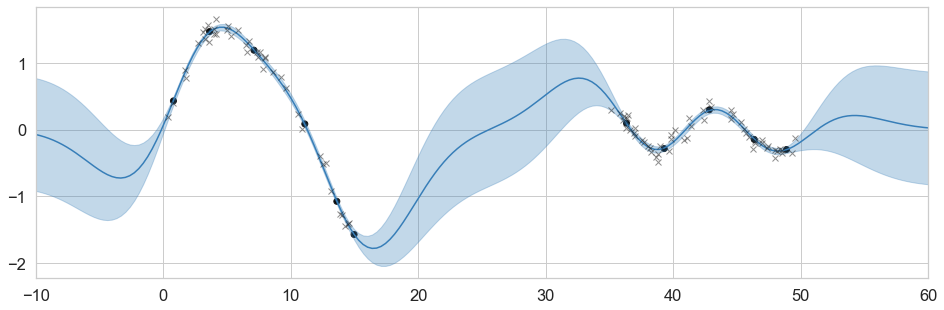

In [9]:
remove_points(gp)
gp.variational_point_process.probabilities = 1.0
model.fit(X=X, Y=Y, max_epochs=300)
plot_svgp()

## Changing the prior

In the above example, we arbitrarily set the prior rate, $\alpha$, to 1. This (fixed) hyper-parameter denotes the strength of the prior, meaning that a higher value encourages stronger pruning. A suitable value is situation specific (e.g. are we running the model on a laptop or a GPU-cluster).

If we re-run the above demonstration with a lower prior, we will see that more points remain in the final model.

Pre-fitting



Pruning



Post-fitting


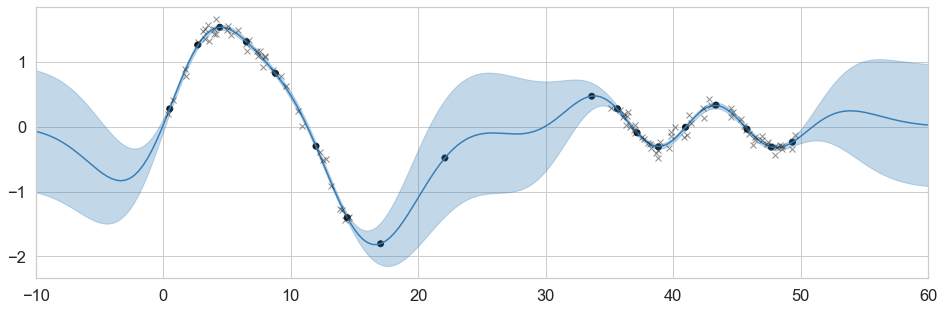

In [10]:
# Re-initialise model
model = get_model(dataset, n_inducing=M, scale_X=False, scale_Y=False)
gp, = model.gps
gp.inducing_inputs = torch.linspace(-10, 60, M)
gp.prior_point_process.rate.fill_(5e-2)

print("Pre-fitting")
model.fit(X=X, Y=Y, max_epochs=300)

print("Pruning")
model.fit_score_function_estimator(
    X=X, Y=Y, learning_rate=0.3, max_epochs=500,
    n_mcmc_samples=8)
remove_points(gp)
gp.variational_point_process.probabilities = 1.0

print("Post-fitting")
model.fit(X=X, Y=Y, max_epochs=300)

plot_svgp()